# INSTAGRAM: DETECCIÓN DE USUARIOS FALSOS

## **Entrenamiento y evaluación de modelos**

<img src="https://miracomohacerlo.com/wp-content/uploads/2019/02/como-ver-a-que-fotos-le-da-like-en-instagram-una-persona-2.jpg" />

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import HTML, display
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn_pandas import DataFrameMapper

## **DATASET**

In [3]:
dataset_original = pd.read_csv('instagram.csv')
dataset = dataset_original

renamed_columns = {'pos':'post','flw':'followers','flg':'following','bl':'biography_lenght','pic':'profile_picture','lin':'external_url','cl':'post_lenght','cz':'post_lenght_null','ni':'none_image','erl':'engagement_rate_likes','erc':'engagement_rate_comments','lt':'post_location','hc':'hashtags_post','pr':'hashtags_promotional','fo':'hashtags_followers','cs':'cosine_similarity','pi':'interval_post','class':'user_class'}
dataset.rename(columns = renamed_columns, inplace = True)

dataset["user_class"] = dataset.user_class.replace(['f','r'], [0, 1])

### **Train, Validation, Test**

In [4]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(dataset, test_size=0.4)
validation, test = train_test_split(not_train, test_size=0.5)

## **MÉTRICAS**

1) Se debe elegir y definir una **métrica de performance** a utilizar para **evaluar los modelos**. Fundamentar la elección de la métrica.


Elegimos la métrica **Precision** ya que al momento de predecir queremos estar seguros de que una cuenta falsa realmente lo sea. No nos daría lo mismo que el modelo prediga que una cuenta es falsa si no lo es a que prediga que es verdadera cuando en realidad es falsa. Nos interesa saber del total de cuentas falsas predichas cuales realmente lo fueron. 
Bajo este sustento no podríamos utilizar **Acurracy** porque tiene diferente impacto errar en la predicción de una clase u otra. A su vez creemos que tampoco nos parece adecuado utilizar **Recall** porque se le estaría dando un tratamiento inapropiado a cuentas que se clasificaron como falsas pero que en realidad eran verdaderas. 

Si bien a continuación vamos a evaluar los modelos con todas las métricas, le vamos a dar mas importancia a Precision. 


2) Se debe aplicar alguna **técnica de feature engineering** para mejorar la data de entrada a los modelos, y mostrar la comparativa de los resultados obtenidos en cada caso. Si no es posible o útil, fundamentar el motivo por el cual no se realizará.

## FEATURE ENGINEERING

### Binning: 
Utilizamos la técnica de redondeo para las siguientes variables:
- post
- followers
- followings
- biography_lenght
- post_lenght
- engagement_rate_likes
- engagement_rate_comments
- hashtags_post
- hashtags_promotional
- hashtags_followers
- interval_post

### One-hotEnconder:
Generamos nuevas columnas a partir de las siguientes variables:
- Profile_picture
- External_URL

Consideramos que las siguientes variables no necesitan una transformación ya que contienen valores que corresponden a porcentajes entre 0 y 1:
- post_lenght_null
- none_image
- post_location
- cosine_similarity

### **MAPPER**

In [5]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [6]:
mapper = DataFrameMapper([
    (['post'], [StandardScaler()]),
    (['followers'], [StandardScaler()]),
    (['following'], [StandardScaler()]),
    (['biography_lenght'], [StandardScaler()]),
    (['profile_picture'], [OneHotEncoder()]),
    (['external_url'], [OneHotEncoder()]),
    (['post_lenght'], [StandardScaler()]),
    (['post_lenght_null'], None),
    (['none_image'], None),
    (['engagement_rate_likes'], [StandardScaler()]),
    (['engagement_rate_comments'], [StandardScaler()]),
    (['post_location'], None),
    (['hashtags_post'], [StandardScaler()]),
    (['hashtags_promotional'], [StandardScaler()]),
    (['hashtags_followers'], [StandardScaler()]),
    (['cosine_similarity'], None),
    (['interval_post'], [StandardScaler()])
])

mapper.fit(train)
mapper.transform(train)

array([[ 0.15884979, -0.03147555, -0.31283003, ..., -0.09395643,
         0.015142  , -0.02630402],
       [ 0.14592417, -0.00282953, -0.0817034 , ..., -0.09395643,
         0.377125  , -0.43035003],
       [ 0.00374238, -0.0623431 , -0.35135113, ..., -0.09395643,
         0.039284  , -0.4018717 ],
       ...,
       [-0.11646586, -0.08794914, -0.46691444, ..., -0.09395643,
         0.29826301,  0.45897866],
       [-0.1862642 , -0.04118012,  0.76576088, ..., -0.09395643,
         0.132273  , -0.42456211],
       [ 0.20150432, -0.06970922, -0.68070657, ...,  0.00916241,
         0.10716   ,  0.21335419]])

In [7]:
mapper.transformed_names_

['post',
 'followers',
 'following',
 'biography_lenght',
 'profile_picture_x0_0',
 'profile_picture_x0_1',
 'external_url_x0_0',
 'external_url_x0_1',
 'post_lenght',
 'post_lenght_null',
 'none_image',
 'engagement_rate_likes',
 'engagement_rate_comments',
 'post_location',
 'hashtags_post',
 'hashtags_promotional',
 'hashtags_followers',
 'cosine_similarity',
 'interval_post']

3) Por cada modelo, se debe **entrenarlo y evaluar** su comportamiento con la **métrica** elegida. Sacar conclusiones respecto a los motivos por los cuales el modelo funciona bien o mal.

## **MODELOS**

### **Función para evaluar modelos**

In [8]:
from sklearn import metrics

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.pipeline import Pipeline

In [9]:
def evaluate_model(model, set_names=('train', 'validation'), title='', show_cm=True):
    if title:
        display(title)
        
    final_metrics = defaultdict(list)
    
    if show_cm:
        fig, axis = plt.subplots(1, len(set_names), sharey=True, figsize=(15, 3))
    
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name]  # <- hack feo...

        y = set_data.user_class
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            ax = axis[i]
            sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=False)

            ax.set_title(set_name)
            ax.xaxis.set_ticklabels(['real', 'fake'])
            ax.yaxis.set_ticklabels(['real', 'fake'])
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')

        
    display(pd.DataFrame(final_metrics, index=set_names))
    if show_cm:
        plt.tight_layout()
        plt.show()

### **REGRESIÓN LOGÍSTICA**

In [30]:
from sklearn.linear_model import LogisticRegression

,Accuracy,Precision,Recall,F1
train,0.808368,0.796372,0.826986,0.811390
validation,0.812629,0.800863,0.828994,0.814686


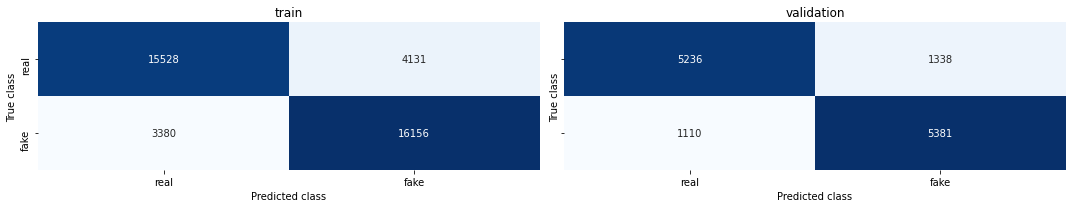

In [31]:
model_lr = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', LogisticRegression(random_state=42)),
])

model_lr.fit(train, train.user_class)

evaluate_model(model_lr)

Podemos observar que **en validation obtivimos un 80% de acierto con la métrica precision al clasificar cuentas falsas.** A su vez observamos que si bien es muy poca la diferencia de los casos reales que erró con los casos falsos que erró, esta última resulta mayor. 

#### Importancias de variables

<AxesSubplot:xlabel='coeficiente', ylabel='feature'>

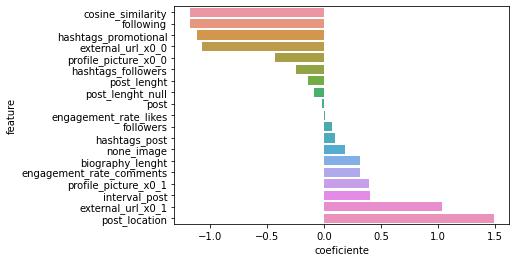

In [18]:
clf = model_lr.named_steps['classifier']
clf.coef_  # los pesos que aprendió la regresión logística!

df_importance = pd.DataFrame({
    'feature': mapper.transformed_names_, 
    'coeficiente': clf.coef_[0],
}).sort_values(by='coeficiente')

sns.barplot(data=df_importance, x='coeficiente', y='feature')

**Conclusiones:**
- Cuanto mas cantidad de following tenga un cuenta, mas probabilidades tiene de ser falsa. 
- Cuanto mas cantidad de uso de hashtags promocionales tenga una cuenta, mas probabilidades tiene de ser falsa. 
- Cuanto mas porcentaje de publicaciones con ubicación tenga una cuenta, mas probabilidades tiene de ser real. 
- Si la variable external_URL es 0, mas probabilidades hay de que la cuenta sea falsa. En cambio si es 1 de que sea real.


### **K NEAREST NEIGHBORS**

In [33]:
from sklearn.neighbors import KNeighborsClassifier

'Knn'

,Accuracy,Precision,Recall,F1
train,0.857788,0.844571,0.875870,0.859936
validation,0.835438,0.824391,0.849792,0.836899


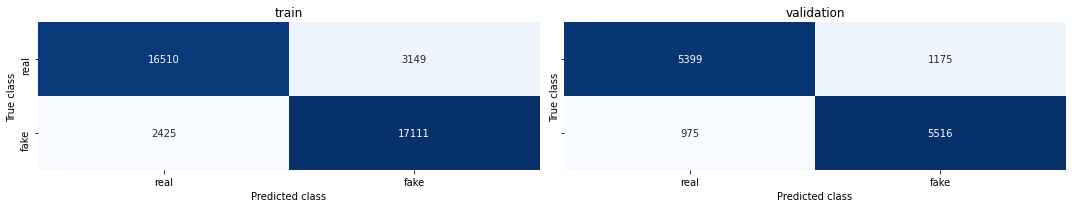

In [34]:
K = 10

model_knn = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

model_knn.fit(train, train.user_class)

evaluate_model(model_knn, title='Knn')

Observamos que en validation obtivimos un **83% de acierto** con la métrica precision al clasificar cuentas falsas. 

### **ÁRBOLES DE DECISIÓN**

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,1.000000,1.000000,1.000000,1.000000
validation,0.852736,0.855963,0.845941,0.850922


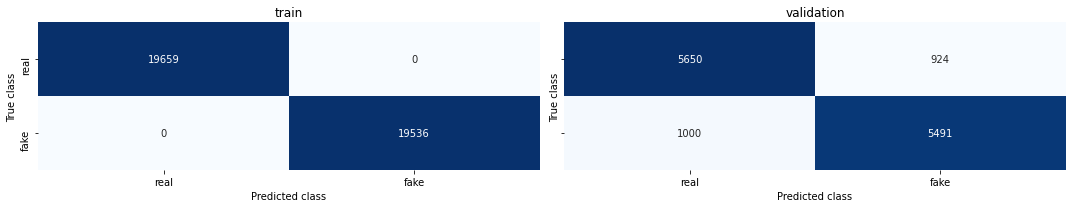

In [11]:
model_tree = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42)),
])

model_tree.fit(train, train.user_class)

evaluate_model(model_tree, title='Decision Tree')

Podemos observar que **en train el algorítmo aciertó casi todos los casos**. Sin embargo en validation observamos que si tuvo fallas a la hora de predecir por lo que entendemos que en train está haciendo **overfiting.** 

Por lo cual agregamos un valor de máxima profundidad: 

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.90259,0.846914,0.982084,0.909505
validation,0.89093,0.836388,0.970267,0.898367


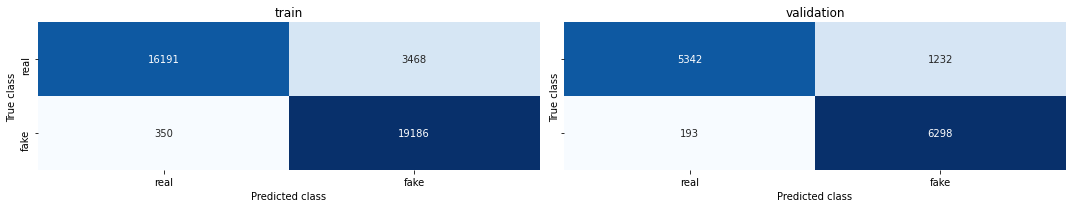

In [12]:
model_tree_maxdepth = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', DecisionTreeClassifier(max_depth = 10, random_state=42)),
])

model_tree.fit(train, train.user_class)

evaluate_model(model_tree, title='Decision Tree')

Agregando un límite de profundidad obtuvimos mejores resultados con **85% de precision.**

### **RANDOM FOREST**

In [17]:
from sklearn.ensemble import RandomForestClassifier

'Random Forest'

,Accuracy,Precision,Recall,F1
train,1.000000,1.00000,1.000000,1.000000
validation,0.903023,0.85978,0.961639,0.907861


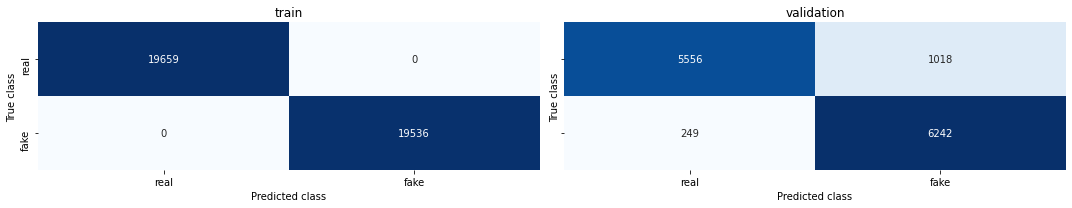

In [22]:
forest_model = RandomForestClassifier(random_state=42)

model_rf = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model),
])

model_rf.fit(train, train.user_class)

evaluate_model(model_rf, title='Random Forest')

Observamos que al no indicar un límite de profundidad y cantidad de estimadores obtenemos una precisión de 1, por lo que entendemos que el algorítmo **está sobreentrenando.** 

'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.848195,0.813851,0.901669,0.855512
validation,0.852660,0.816556,0.907256,0.859520


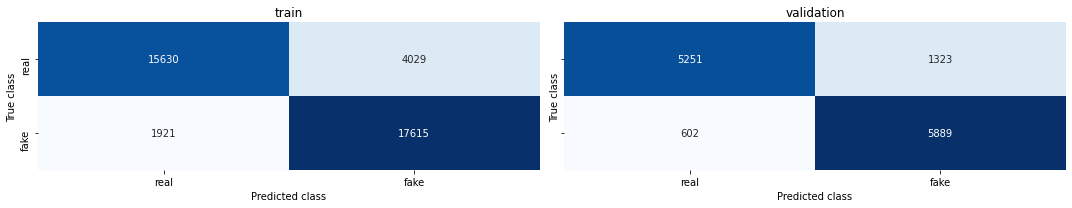

In [24]:
forest_model = RandomForestClassifier(n_estimators=100, max_depth=3, max_features=2, random_state=42)

model_rf_maxdepth = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model),
])

model_rf.fit(train, train.user_class)

evaluate_model(model_rf, title='Random Forest')


Observamos que, para un valor de **100 arboles** y un **limite de profudidad de 10,** obtenemos un **82% de precisión** en la predicones realizadas tanto en train como en validation. 


### **GRADIENT BOOSTED TREES**

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
boost_model = GradientBoostingClassifier(random_state=42)

model_gradient_boosted = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', boost_model),
])

model_gradient_boosted.fit(train, train.user_class)

evaluate_model(model_gradient_boosted, title='Gradient Boosting')

Observamos que en validation obtivimos un **85% de acierto con la métrica precision** al clasificar cuentas.

4) Se deben utilizar **técnicas** que garanticen que los modelos no están **sobreentrenando** sin que nos demos cuenta.

### EVITANDO OVERFITING

Para evitar que los modelos sobreentrenen utilizamos: 
- Límite de profundidad en Arboles de decisión
- Límite de profundidad y máximo de estimadores en Radom Forest


5) Determinar el valor final de la **métrica** que podría ser informado al cliente, utilizando técnicas que permitan obtener un valor lo más realista posible. Fundamentar.

In [35]:
evaluate_model(model_lr, title='Regresión Logística', set_names=('train', 'test', 'validation'), show_cm=False)
evaluate_model(model_knn, title='KNN', set_names=('train', 'test', 'validation'), show_cm=False)
evaluate_model(model_tree, title='Arbol de decisión', set_names=('train', 'test', 'validation'), show_cm=False)
evaluate_model(model_rf, title='Random Forest', set_names=('train', 'test', 'validation'), show_cm=False)
evaluate_model(model_gradient_boosted, title='Gradient Boosting', set_names=('train', 'test', 'validation'), show_cm=False)


'Regresión Logística'

,Accuracy,Precision,Recall,F1
train,0.808368,0.796372,0.826986,0.811390
test,0.809276,0.793622,0.827919,0.810408
validation,0.812629,0.800863,0.828994,0.814686


'KNN'

,Accuracy,Precision,Recall,F1
train,0.857788,0.844571,0.875870,0.859936
test,0.835068,0.816420,0.857920,0.836656
validation,0.835438,0.824391,0.849792,0.836899


'Arbol de decisión'

,Accuracy,Precision,Recall,F1
train,0.902590,0.846914,0.982084,0.909505
test,0.888413,0.832687,0.967822,0.895183
validation,0.890930,0.836388,0.970267,0.898367


'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.848195,0.813851,0.901669,0.855512
test,0.847314,0.807341,0.906109,0.853878
validation,0.852660,0.816556,0.907256,0.859520


'Gradient Boosting'

,Accuracy,Precision,Recall,F1
train,0.900089,0.855000,0.962838,0.905720
test,0.896755,0.849368,0.960672,0.901597
validation,0.900115,0.854042,0.963642,0.905537
